# Transformer Hands-On Tutorial: Sentiment Classification & Embedding Visualization
This notebook walks through using a pretrained transformer model (`DistilBERT`) for sentiment classification on IMDb reviews, while exploring tokenizer behavior and token embeddings visually.

## Step 1: Install and Import Libraries


In [19]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
!pip install transformers datasets torch scikit-learn matplotlib ipywidgets
!{sys.executable} -m pip install --upgrade accelerate transformers torch


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE

/Users/adirgigi/Documents/BGU/Thesis/CCC/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 2: Load IMDb Dataset

In [7]:
dataset = load_dataset("imdb")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


---

## Step 3: Initialize Tokenizer and Visualize Tokenization

We use DistilBERT's tokenizer to see how example sentences are split into tokens.

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

example_sentences = [
    "I love deep learning!",
    "Transformers are powerful models.",
    "Tokenization splits text into pieces.",
    "Unbelievable, amazing, and fantastic!",
    "Transformers' abilities are mind-blowing!",
    "Co-operate, re-enter, and co-own show hyphenated words.",
    "COVID-19 pandemic changed the world.",
    "E-mail and e-commerce are everyday terms now.",
    "Emojis like 😊, 🚀, and 🧠 are tokenized separately.",
    "The word 'antidisestablishmentarianism' gets split into many subwords.",
    "Antisemitism"
]

print("\n=== Tokenizer Output Examples ===")

for text in example_sentences:
    encoding = tokenizer(text)
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    print(f"Text: {text}")
    print(f"Tokens: {tokens}")


=== Tokenizer Output Examples ===
Text: I love deep learning!
Tokens: ['[CLS]', 'i', 'love', 'deep', 'learning', '!', '[SEP]']
Text: Transformers are powerful models.
Tokens: ['[CLS]', 'transformers', 'are', 'powerful', 'models', '.', '[SEP]']
Text: Tokenization splits text into pieces.
Tokens: ['[CLS]', 'token', '##ization', 'splits', 'text', 'into', 'pieces', '.', '[SEP]']
Text: Unbelievable, amazing, and fantastic!
Tokens: ['[CLS]', 'unbelievable', ',', 'amazing', ',', 'and', 'fantastic', '!', '[SEP]']
Text: Transformers' abilities are mind-blowing!
Tokens: ['[CLS]', 'transformers', "'", 'abilities', 'are', 'mind', '-', 'blowing', '!', '[SEP]']
Text: Co-operate, re-enter, and co-own show hyphenated words.
Tokens: ['[CLS]', 'co', '-', 'operate', ',', 're', '-', 'enter', ',', 'and', 'co', '-', 'own', 'show', 'h', '##yp', '##hen', '##ated', 'words', '.', '[SEP]']
Text: COVID-19 pandemic changed the world.
Tokens: ['[CLS]', 'co', '##vid', '-', '19', 'pan', '##de', '##mic', 'changed', '

---

## Step 4: Load Model and Visualize Token Embeddings with t-SNE

Visualize the embeddings of selected tokens in 2D space to understand their relative similarities.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


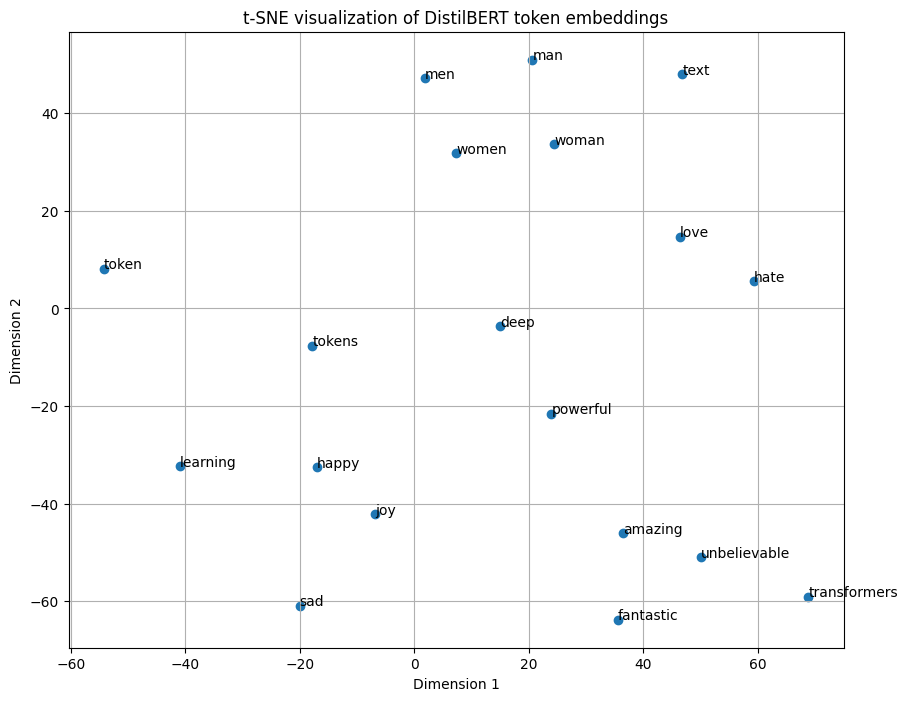

In [9]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
embedding_layer = model.distilbert.embeddings.word_embeddings

tokens_to_viz = [
    "deep", "learning", "transformers", "powerful", "token", "tokens",
    "text", "love", "hate", "happy", "sad", "joy", "unbelievable", "amazing", "fantastic",
    "man", "men", "woman", "women"
]

token_ids = tokenizer.convert_tokens_to_ids(tokens_to_viz)
embeddings = embedding_layer.weight[token_ids].detach().cpu().numpy()

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

for i, token in enumerate(tokens_to_viz):
    plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]))


plt.title("t-SNE visualization of DistilBERT token embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()



## Step 5: Tokenize the Entire Dataset

Apply the tokenizer to the whole IMDb dataset with padding and truncation.

In [10]:
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenize_batch, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

---

## Step 6: Define Metrics Function for Evaluation

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    pred = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='binary')
    acc = accuracy_score(labels, pred)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

---

## Step 7: Setup Training Arguments

In [30]:
!pip install "transformers[torch]"
!pip install 'accelerate>=0.26.0'


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [12]:
training_args = TrainingArguments(
    output_dir='./output',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    load_best_model_at_end=True,
)

---

## Step 8: Initialize Trainer

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'].shuffle(seed=42).select(range(5000)),  # small subset
    eval_dataset=encoded_dataset['test'].shuffle(seed=42).select(range(1000)),
    compute_metrics=compute_metrics,
)

---

## Step 9: Train the Model

In [14]:
trainer.train()

/Users/adirgigi/Documents/BGU/Thesis/CCC/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.357800,0.866000,0.805172,0.956967,0.874532
2,0.284400,0.293882,0.899000,0.871401,0.930328,0.899901


/Users/adirgigi/Documents/BGU/Thesis/CCC/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=626, training_loss=0.25554426638082195, metrics={'train_runtime': 2604.0173, 'train_samples_per_second': 3.84, 'train_steps_per_second': 0.24, 'total_flos': 1324673986560000.0, 'train_loss': 0.25554426638082195, 'epoch': 2.0})

---

## Step 10: Evaluate Model on Test Set

In [15]:
eval_results = trainer.evaluate()
print(f"\nEvaluation results: {eval_results}")

/Users/adirgigi/Documents/BGU/Thesis/CCC/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Evaluation results: {'eval_loss': 0.29388150572776794, 'eval_accuracy': 0.899, 'eval_precision': 0.8714011516314779, 'eval_recall': 0.930327868852459, 'eval_f1': 0.8999008919722498, 'eval_runtime': 24.8701, 'eval_samples_per_second': 40.209, 'eval_steps_per_second': 0.643, 'epoch': 2.0}


---

## Step 11 (Optional): Predict Sentiment on Custom Texts

In [18]:
def predict_sentiment(text):
    model.eval()
    device = torch.device("cpu")
    model.to(device)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    prediction = "Positive" if predicted_class_id == 1 else "Negative"

    return prediction

custom_texts = [
    "I really enjoyed this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The movie was boring as hell.",
    "I fell asleep watching this movie.",
    "This movie was worth every penny!",
    "It's a must"
]

print("\n=== Custom Sentiment Predictions ===")
for t in custom_texts:
    pred = predict_sentiment(t)
    print(f"Text: {t}\nPredicted sentiment: {pred}\n")



=== Custom Sentiment Predictions ===
Text: I really enjoyed this movie, it was fantastic!
Predicted sentiment: Positive

Text: This was the worst film I have ever seen.
Predicted sentiment: Negative

Text: The movie was boring as hell.
Predicted sentiment: Negative

Text: I fell asleep watching this movie.
Predicted sentiment: Negative

Text: This movie was worth every penny!
Predicted sentiment: Positive

Text: It's a must
Predicted sentiment: Positive

